---
### Importing libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

In [2]:
from xgboost import XGBRegressor

In [3]:
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.preprocessing import StandardScaler

---
### Loading the dataset

In [4]:
df = pd.read_csv('boston.csv')
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,NaN,36.2


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     486 non-null    float64
 1   ZN       486 non-null    float64
 2   INDUS    486 non-null    float64
 3   CHAS     486 non-null    float64
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      486 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    int64  
 9   TAX      506 non-null    int64  
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    486 non-null    float64
 13  MEDV     506 non-null    float64
dtypes: float64(12), int64(2)
memory usage: 55.5 KB


In [6]:
df.dropna(axis=0, inplace=True)
df.reset_index(drop=True, inplace=True)

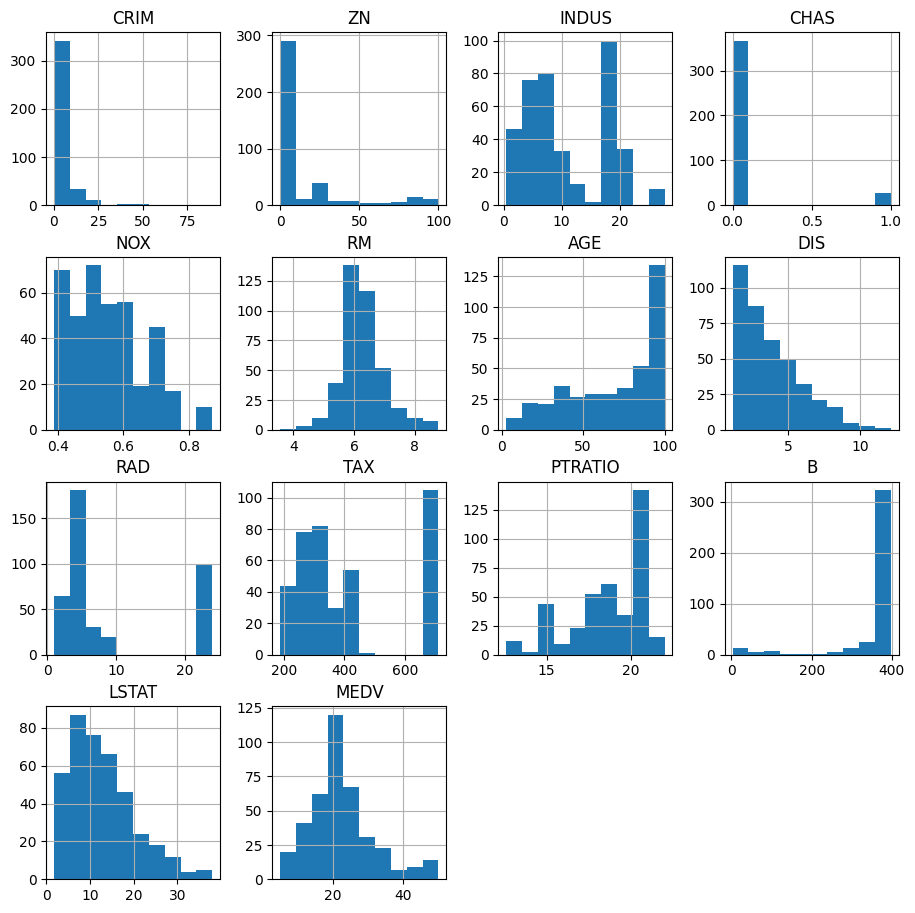

In [7]:
df.hist(figsize=(11,11))
plt.show()

In [8]:
selected_features = ['AGE', 'RAD', 'TAX', 'DIS', 'RM',
                     'LSTAT', 'B', 'INDUS', 'CHAS']

In [9]:
X = df[selected_features]
y = df.MEDV

In [10]:
X.head()

,AGE,RAD,TAX,DIS,RM,LSTAT,B,INDUS,CHAS
0,65.2,1,296,4.0900,6.575,4.98,396.90,2.31,0.0
1,78.9,2,242,4.9671,6.421,9.14,396.90,7.07,0.0
2,61.1,2,242,4.9671,7.185,4.03,392.83,7.07,0.0
3,45.8,3,222,6.0622,6.998,2.94,394.63,2.18,0.0
4,58.7,3,222,6.0622,6.430,5.21,394.12,2.18,0.0


In [11]:
y.head()

0    24.0
1    21.6
2    34.7
3    33.4
4    28.7
Name: MEDV, dtype: float64

In [12]:
X_scaled = pd.DataFrame(StandardScaler().fit_transform(X), columns=X.columns)

In [13]:
X_scaled.head()

,AGE,RAD,TAX,DIS,RM,LSTAT,B,INDUS,CHAS
0,-0.134014,-0.974609,-0.656944,0.135851,0.423161,-1.067126,0.430740,-1.259620,-0.271237
1,0.357849,-0.858633,-0.978184,0.554334,0.202245,-0.497196,0.430740,-0.569724,-0.271237
2,-0.281214,-0.858633,-0.978184,0.554334,1.298216,-1.197278,0.385097,-0.569724,-0.271237
3,-0.830521,-0.742657,-1.097162,1.076829,1.029962,-1.346610,0.405283,-1.278462,-0.271237
4,-0.367380,-0.742657,-1.097162,1.076829,0.215156,-1.035615,0.399564,-1.278462,-0.271237


---
### LIME Implementation

In [14]:
def generate_perturbed_samples(data_point, num_samples, scale):
    data_point = np.array(data_point)
    num_features = data_point.shape[0]
    
    perturbations = np.random.normal(0, 1, (num_samples, num_features))
    perturbed_samples = data_point + scale*perturbations
    
    return perturbed_samples

In [15]:
interpretable_models = [Lasso(alpha=0.3),
                        Lasso(alpha=0.7),
                        DecisionTreeRegressor(max_depth=2),
                        DecisionTreeRegressor(max_depth=3),
                        DecisionTreeRegressor(max_depth=4),
                        DecisionTreeRegressor()
                       ]

In [16]:
def calculate_penalty(model):
    if isinstance(model, DecisionTreeRegressor):
        return model.get_depth()
    return np.count_nonzero(model.coef_)

In [17]:
def calculate_proximity(x, z, sigma):
    d = np.linalg.norm(x - z)
    # return math.exp(-(d/sigma)**2)
    return 1/d + 1e-8

In [18]:
def calculate_loss(X, y, trained_complex_model, interpretable_model, num_samples, perturb_scale, prox_sigma):    
    cm = trained_complex_model
    im = interpretable_model
    im.fit(X.values, y)
    
    l = 0

    for x in X.values:
        for z in generate_perturbed_samples(x, num_samples=num_samples, scale=perturb_scale):
            prox = calculate_proximity(x, z, prox_sigma)
            pena = calculate_penalty(im)
            l += (cm.predict(np.array([z])) - im.predict(np.array([z]))[0])**2 * prox + pena
            
    return im, l/(X.shape[0]*num_samples)

In [19]:
def return_lime_results(X, y, complex_model, interpretable_models, num_samples=50, perturb_scale=2, prox_sigma=0.1):
    cm = complex_model
    cm.fit(X, y)
    
    min_loss = float('inf')
    best_model = None
    
    loss_data = []
    for im in interpretable_models:
        print('computing...')
        trained_im, l = calculate_loss(X, y, cm, im, num_samples, perturb_scale, prox_sigma)
        if l[0] < min_loss:
            best_model = trained_im
            min_loss = l[0]
        loss_data.append((trained_im,l[0]))
    
    print('completed successfully!')
    return best_model, loss_data

---
### Applying LIME

In [25]:
best_model, loss_data = return_lime_results(X_scaled[:100], y[:100], XGBRegressor(), interpretable_models)

computing...
computing...
computing...
computing...
computing...
computing...
completed successfully!


In [26]:
loss_data

[(Lasso(alpha=0.3), 16.105772),
 (Lasso(alpha=0.7), 10.975143),
 (DecisionTreeRegressor(max_depth=2), 6.952047),
 (DecisionTreeRegressor(max_depth=3), 9.172586),
 (DecisionTreeRegressor(max_depth=4), 10.162239),
 (DecisionTreeRegressor(), 18.816906)]

In [27]:
best_model

DecisionTreeRegressor(max_depth=2)

In [28]:
pd.DataFrame([best_model.feature_importances_], columns=X_scaled.columns.tolist())

,AGE,RAD,TAX,DIS,RM,LSTAT,B,INDUS,CHAS
0,0.102069,0.0,0.0,0.0,0.213658,0.684273,0.0,0.0,0.0


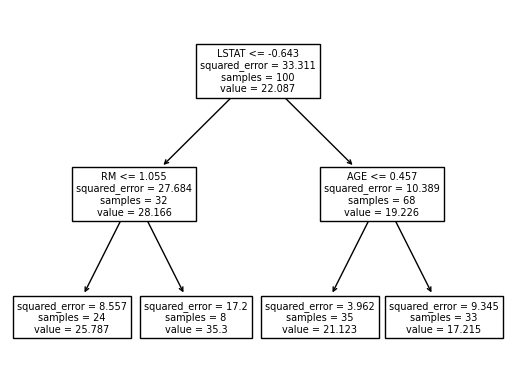

In [29]:
plot_tree(best_model, feature_names=X_scaled.columns.tolist())
plt.show()

---